In [67]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [68]:
dataset = 'model/two_hands_keypoint_classifier/two_hands_keypoint_video.csv'
model_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5'

# 分類数設定

In [69]:
NUM_CLASSES = 6

# 学習データ読み込み

In [70]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2 * 2) + 1)))

In [71]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2 * 2, )),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [74]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 80)                6800      
                                                                 
 dropout_9 (Dropout)         (None, 80)                0         
                                                                 
 dense_16 (Dense)            (None, 40)                3240      
                                                                 
 dropout_10 (Dropout)        (None, 40)                0         
                                                                 
 dense_17 (Dense)            (None, 20)                820       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_18 (Dense)            (None, 10)               

In [75]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [76]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [77]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


22/23 [===========================>..] - ETA: 0s - loss: 1.6389 - accuracy: 0.3036 
Epoch 1: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
23/23 [==============================] - 2s 13ms/step - loss: 1.6357 - accuracy: 0.3046 - val_loss: 1.3503 - val_accuracy: 0.4033
Epoch 2/1000
21/23 [==========================>...] - ETA: 0s - loss: 1.3317 - accuracy: 0.4178
Epoch 2: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
23/23 [==============================] - 0s 6ms/step - loss: 1.3194 - accuracy: 0.4262 - val_loss: 1.0013 - val_accuracy: 0.5613
Epoch 3/1000
 1/23 [>.............................] - ETA: 0s - loss: 1.2665 - accuracy: 0.3906

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/23 [=========================>....] - ETA: 0s - loss: 1.0525 - accuracy: 0.5367
Epoch 3: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
23/23 [==============================] - 0s 7ms/step - loss: 1.0336 - accuracy: 0.5475 - val_loss: 0.5867 - val_accuracy: 0.8399
Epoch 4/1000
21/23 [==========================>...] - ETA: 0s - loss: 0.7117 - accuracy: 0.7117
Epoch 4: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
23/23 [==============================] - 0s 6ms/step - loss: 0.7082 - accuracy: 0.7148 - val_loss: 0.2764 - val_accuracy: 0.9969
Epoch 5/1000
20/23 [=========================>....] - ETA: 0s - loss: 0.4787 - accuracy: 0.8520
Epoch 5: saving model to model/two_hands_keypoint_classifier/two_hands_keypoint_classifier.hdf5
23/23 [==============================] - 0s 6ms/step - loss: 0.4743 - accuracy: 0.8527 - val_loss: 0.1121 - val_accuracy: 0.9969
Epoch 6/1000
21/23 [==========================>...

In [78]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 [==============================] - 0s 2ms/step - loss: 0.0464 - accuracy: 0.9990


In [79]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [80]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 80ms/step
[1.5818116e-05 9.9998188e-01 1.1184720e-09 2.2214547e-06 1.6658952e-13
 1.2424806e-09]
1


# 混同行列

 1/31 [..............................] - ETA: 0s

31/31 [==============================] - 0s 4ms/step


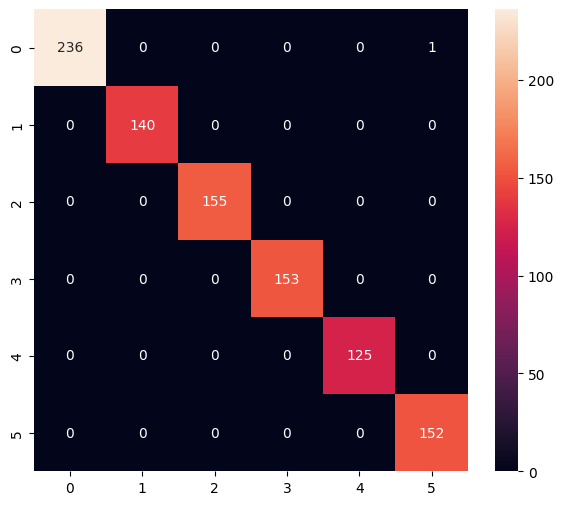

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       237
           1       1.00      1.00      1.00       140
           2       1.00      1.00      1.00       155
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       125
           5       0.99      1.00      1.00       152

    accuracy                           1.00       962
   macro avg       1.00      1.00      1.00       962
weighted avg       1.00      1.00      1.00       962



In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [82]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

/tmp/myenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [83]:
# モデルを変換(量子化)
tflite_save_path = 'model/two_hands_keypoint_classifier/two_hands_keypoint_classifier_video.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp9jbx7do7/assets


INFO:tensorflow:Assets written to: /tmp/tmp9jbx7do7/assets
2024-01-11 10:32:04.840394: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-11 10:32:04.840434: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-11 10:32:04.840618: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9jbx7do7
2024-01-11 10:32:04.841958: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-11 10:32:04.841969: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp9jbx7do7
2024-01-11 10:32:04.845473: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-11 10:32:04.906396: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp9jbx7do7
2024-01-11 10:32:04.923604: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

17904

# 推論テスト

In [84]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [85]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [86]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [87]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 979 µs, sys: 0 ns, total: 979 µs
Wall time: 855 µs


In [88]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5842483e-05 9.9998188e-01 1.0931567e-09 2.2918312e-06 1.6907745e-13
 1.2722703e-09]
1
